In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load MNIST dataset
transform = transforms.ToTensor()
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.28MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 153kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.45MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 9.40MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
# Define Autoencoder models
class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, 784)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded.view(-1, 1, 28, 28)

class AutoencoderDropout(nn.Module):
    def __init__(self, latent_dim):
        super(AutoencoderDropout, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, latent_dim),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, 784)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded.view(-1, 1, 28, 28)


In [4]:
# Training function
def train_autoencoder(model, train_loader, test_loader, num_epochs=25, learning_rate=1e-3, weight_decay=1e-5):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    train_losses = []
    test_losses = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for data in train_loader:
            img, _ = data
            optimizer.zero_grad()
            output = model(img)
            loss = criterion(output, img)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * img.size(0)
        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for data in test_loader:
                img, _ = data
                output = model(img)
                loss = criterion(output, img)
                test_loss += loss.item() * img.size(0)
        test_loss = test_loss / len(test_loader.dataset)
        test_losses.append(test_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    return train_losses, test_losses


In [5]:

# Train models
models = {
    '32_l2': Autoencoder(32),
    '64_l2': Autoencoder(64),
    '32_dropout': AutoencoderDropout(32)
}

train_errors = {}
test_errors = {}

for name in models:
    print(f"Training model: {name}")
    model = models[name]
    if 'dropout' in name:
        train_loss, test_loss = train_autoencoder(model, train_loader, test_loader, weight_decay=0)
    else:
        train_loss, test_loss = train_autoencoder(model, train_loader, test_loader)
    train_errors[name] = train_loss[-1]
    test_errors[name] = test_loss[-1]

print("Training errors:", train_errors)
print("Test errors:", test_errors)


Training model: 32_l2
Epoch 1/25, Train Loss: 0.0583, Test Loss: 0.0306
Epoch 2/25, Train Loss: 0.0258, Test Loss: 0.0215
Epoch 3/25, Train Loss: 0.0201, Test Loss: 0.0182
Epoch 4/25, Train Loss: 0.0178, Test Loss: 0.0164
Epoch 5/25, Train Loss: 0.0162, Test Loss: 0.0153
Epoch 6/25, Train Loss: 0.0153, Test Loss: 0.0145
Epoch 7/25, Train Loss: 0.0146, Test Loss: 0.0139
Epoch 8/25, Train Loss: 0.0140, Test Loss: 0.0134
Epoch 9/25, Train Loss: 0.0135, Test Loss: 0.0129
Epoch 10/25, Train Loss: 0.0130, Test Loss: 0.0125
Epoch 11/25, Train Loss: 0.0127, Test Loss: 0.0122
Epoch 12/25, Train Loss: 0.0124, Test Loss: 0.0120
Epoch 13/25, Train Loss: 0.0122, Test Loss: 0.0117
Epoch 14/25, Train Loss: 0.0120, Test Loss: 0.0116
Epoch 15/25, Train Loss: 0.0118, Test Loss: 0.0114
Epoch 16/25, Train Loss: 0.0117, Test Loss: 0.0113
Epoch 17/25, Train Loss: 0.0115, Test Loss: 0.0112
Epoch 18/25, Train Loss: 0.0114, Test Loss: 0.0111
Epoch 20/25, Train Loss: 0.0112, Test Loss: 0.0109
Epoch 21/25, Train

In [6]:
# Function to plot reconstructions
def plot_reconstructions(model, dataloader, num_images=10, title='Reconstructions'):
    model.eval()
    images, _ = next(iter(dataloader))
    with torch.no_grad():
      outputs = model(images[:num_images])
    images = images[:num_images].cpu()
    outputs = outputs.view(-1, 28, 28).cpu()

    plt.figure(figsize=(20, 4))
    for i in range(num_images):
      ax = plt.subplot(2, num_images, i + 1)
      plt.imshow(images[i].squeeze(), cmap='gray')
      ax.axis('off')
      ax = plt.subplot(2, num_images, i + 1 + num_images)
      plt.imshow(outputs[i].squeeze(), cmap='gray')
      ax.axis('off')
    plt.suptitle(title)
    plt.show()


Reconstructions for 32_l2 (Train)


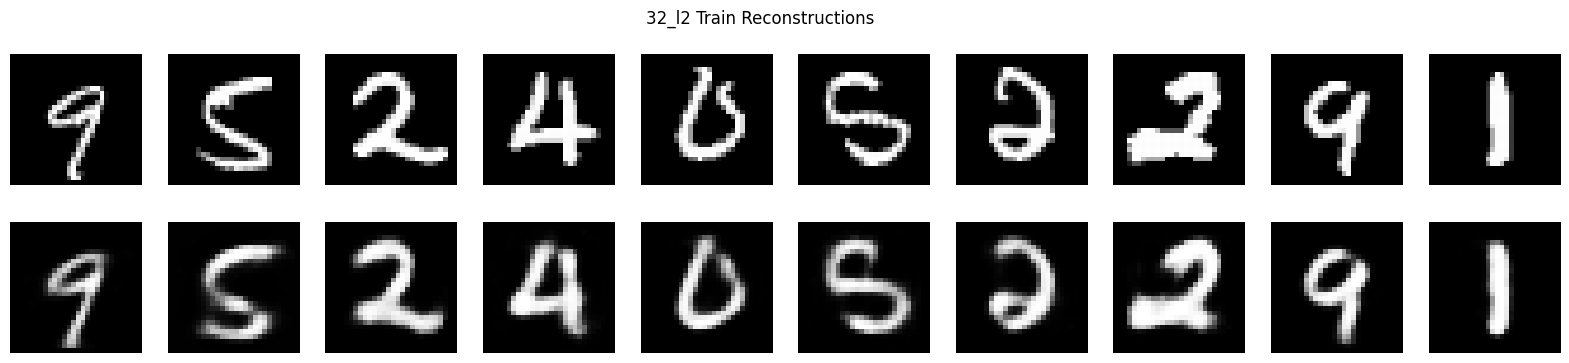

Reconstructions for 32_l2 (Test)


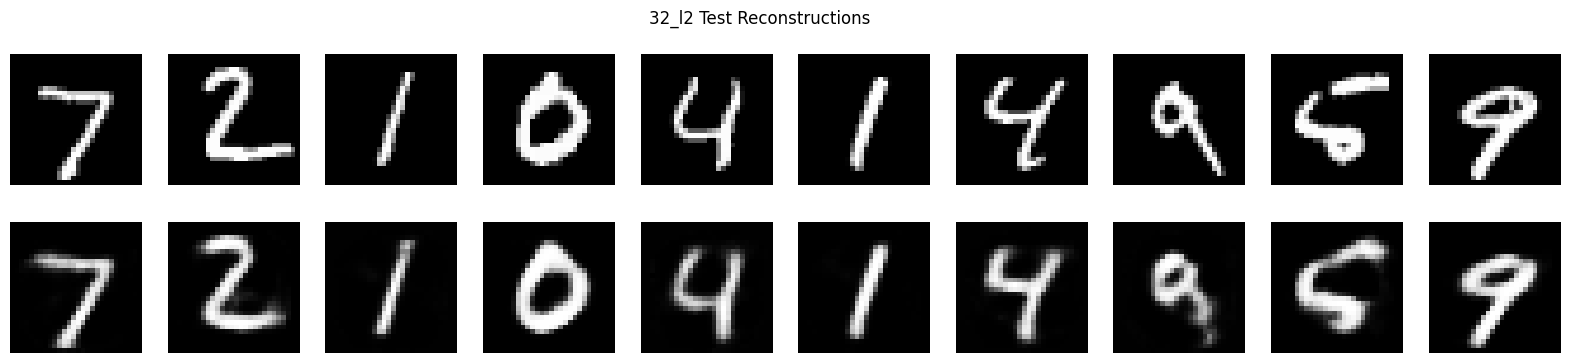

Reconstructions for 64_l2 (Train)


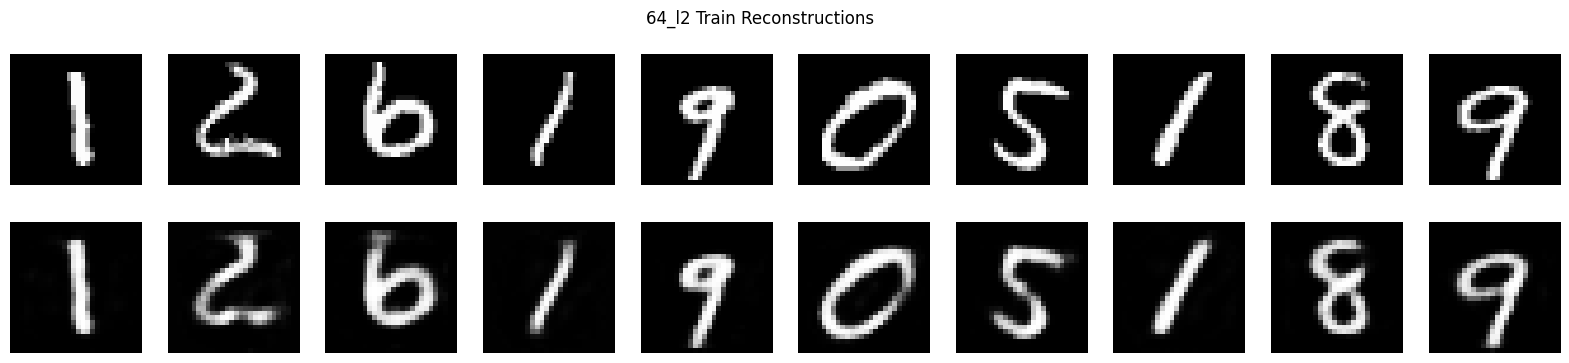

Reconstructions for 64_l2 (Test)


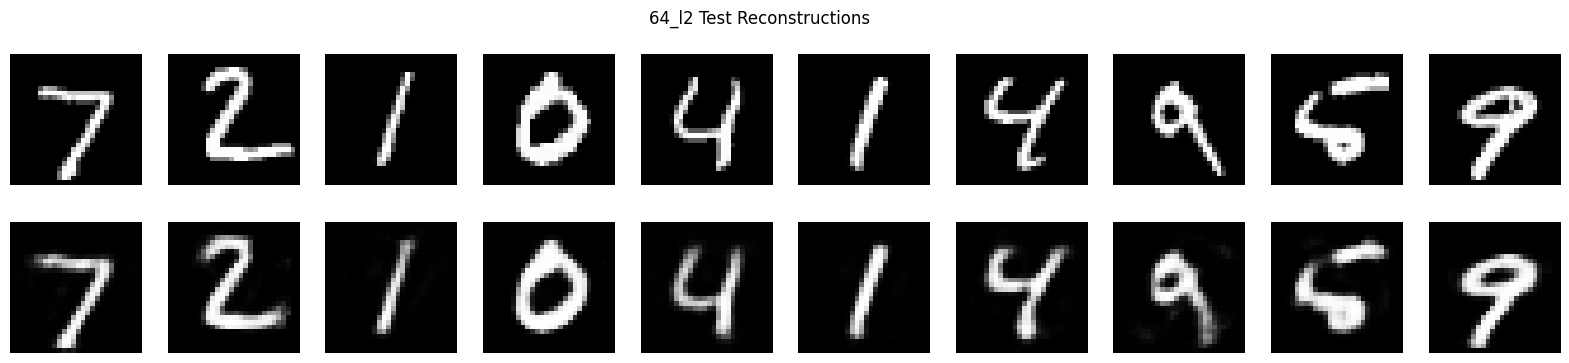

Reconstructions for 32_dropout (Train)


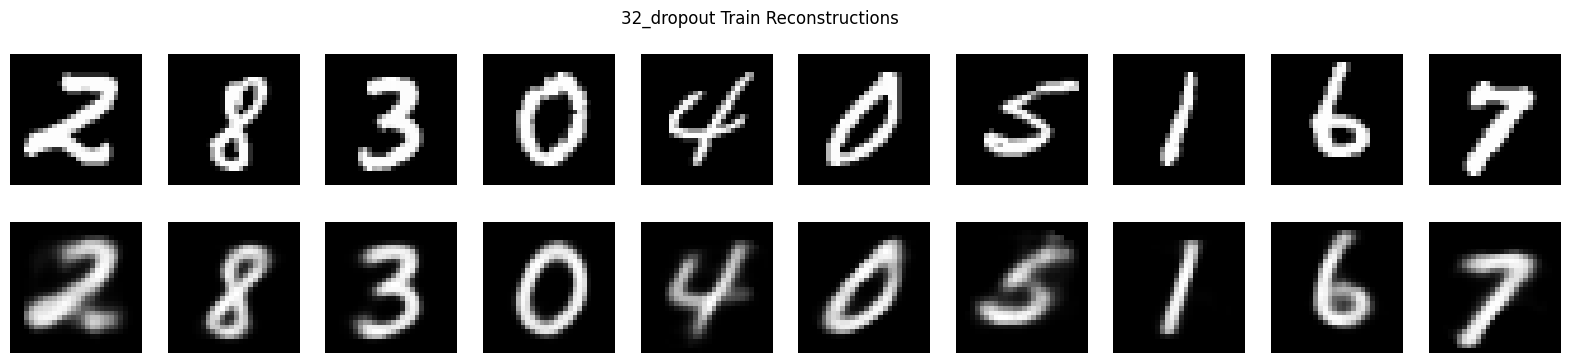

Reconstructions for 32_dropout (Test)


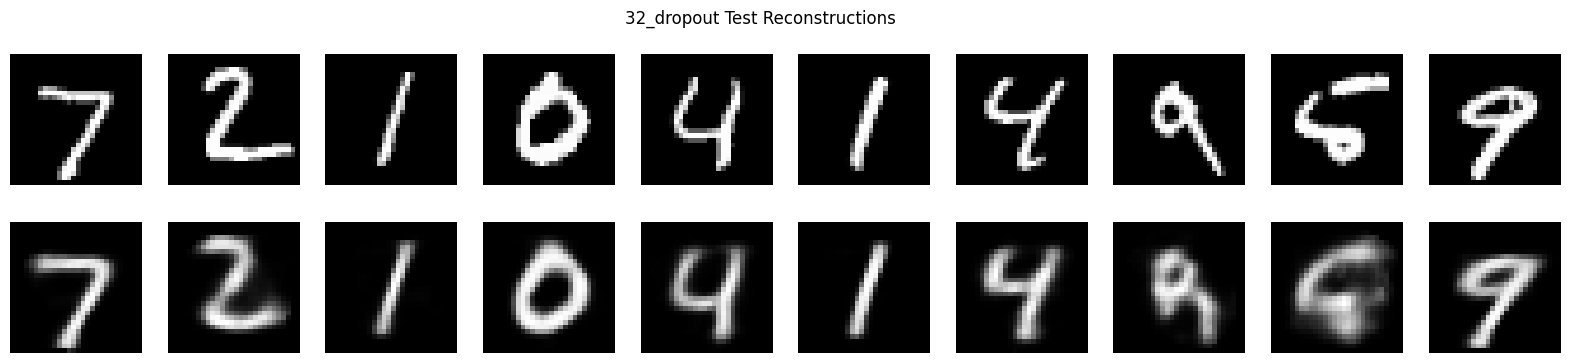

In [7]:

# Plot reconstructions for each model
for name in models:
  print(f"Reconstructions for {name} (Train)")
  plot_reconstructions(models[name], train_loader, title=f'{name} Train Reconstructions')
  print(f"Reconstructions for {name} (Test)")
  plot_reconstructions(models[name], test_loader, title=f'{name} Test Reconstructions')


In [8]:
# Prepare pairs for interpolation
samples = []
for digit in range(10):
  indices = (train_dataset.targets == digit).nonzero().squeeze()
  idx = indices[0].item()
  img, _ = train_dataset[idx]
  samples.append(img)
pairs = [(samples[i], samples[i+1]) for i in range(0, 10, 2)]  # 5 pairs


In [11]:
# Function to interpolate and plot
def plot_interpolations(model, pairs, num_steps=10):
  model.eval()
  for pair_idx, (x1, x2) in enumerate(pairs):
    x1 = x1.unsqueeze(0)
    x2 = x2.unsqueeze(0)

    with torch.no_grad():
      z1 = model.encoder(x1.view(-1, 784))
      z2 = model.encoder(x2.view(-1, 784))

    alphas = torch.linspace(0, 1, num_steps)
    interpolated = []
    for alpha in alphas:
      z = alpha * z1 + (1 - alpha) * z2
      output = model.decoder(z).view(1, 28, 28)
      interpolated.append(output.squeeze().detach().cpu().numpy())

    plt.figure(figsize=(num_steps*2, 2))
    for j in range(num_steps):
      ax = plt.subplot(1, num_steps, j+1)
      plt.imshow(interpolated[j], cmap='gray')
      ax.axis('off')

    plt.suptitle(f'Interpolation Pair {pair_idx+1}')
    plt.show()


Interpolations for model: 32_l2


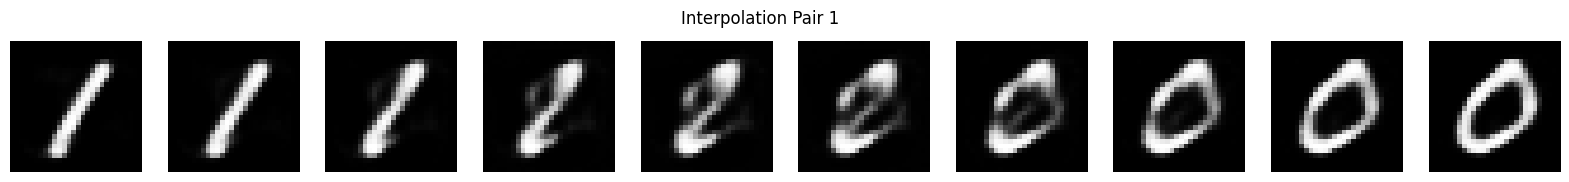

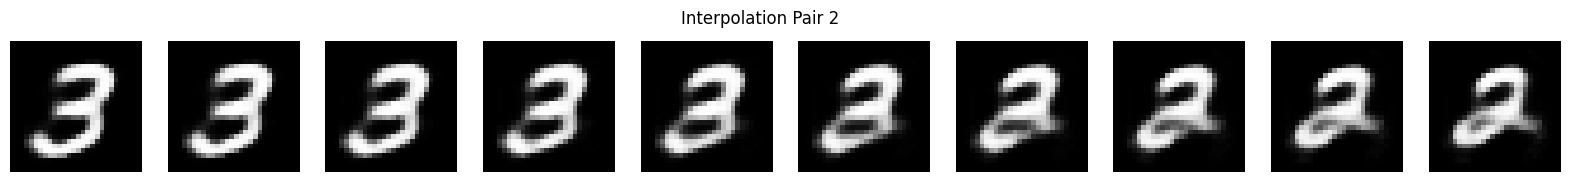

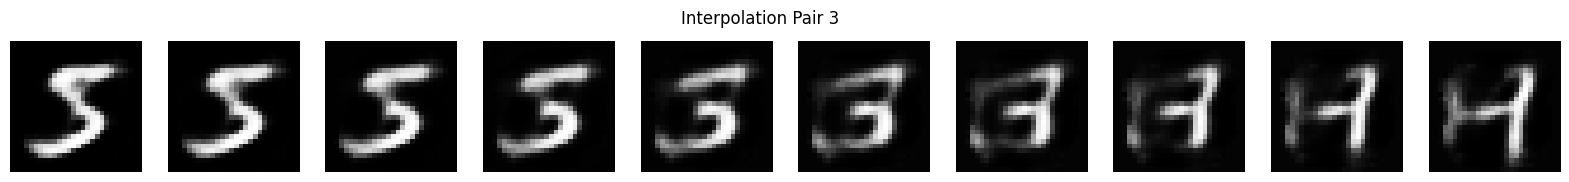

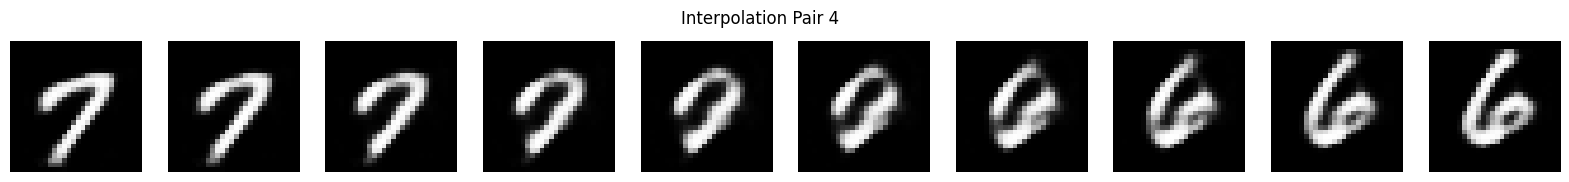

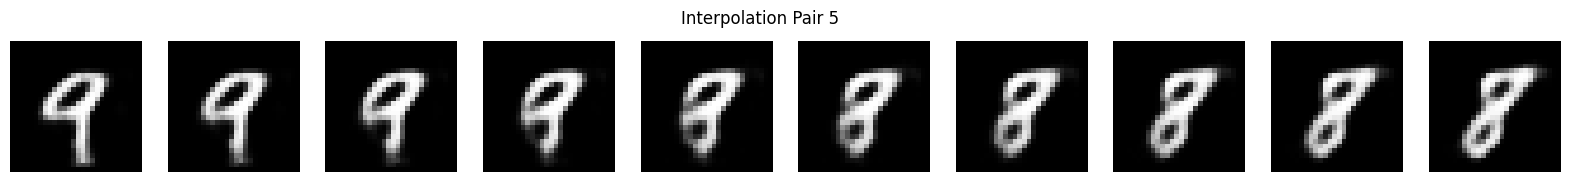

Interpolations for model: 64_l2


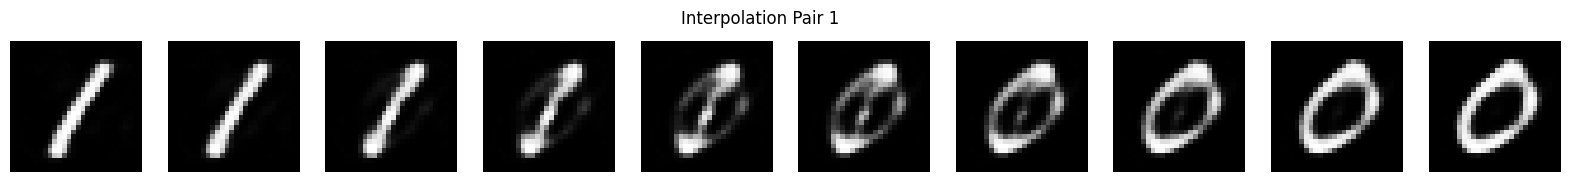

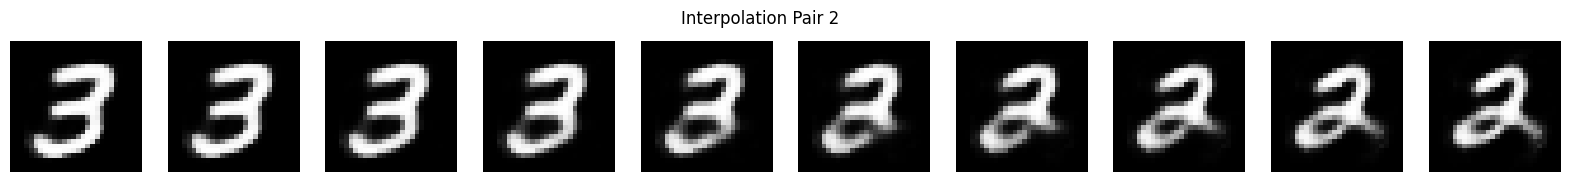

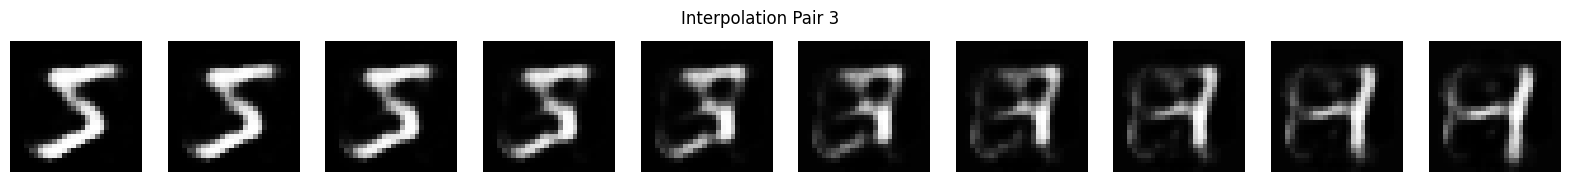

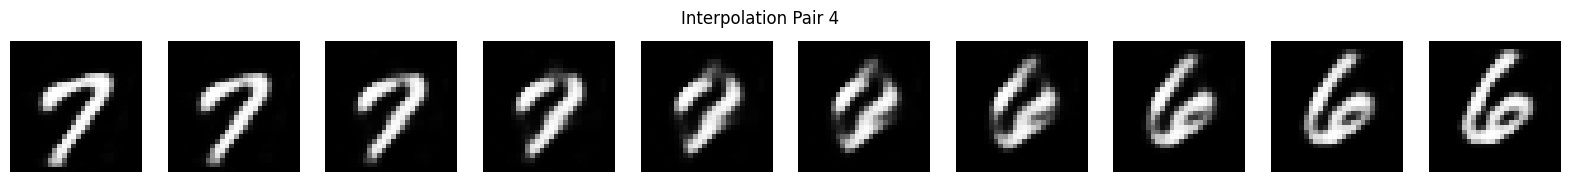

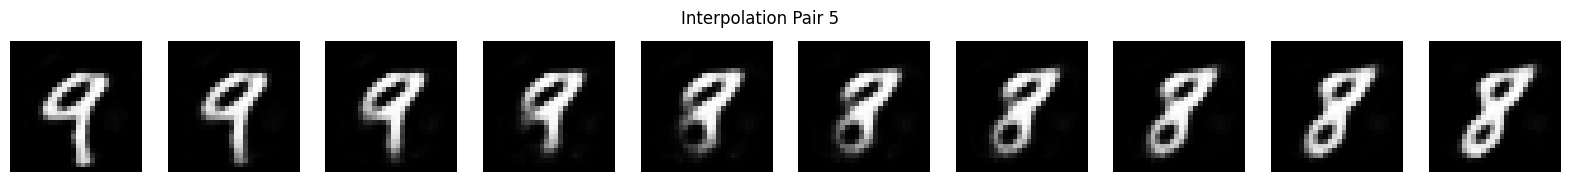

Interpolations for model: 32_dropout


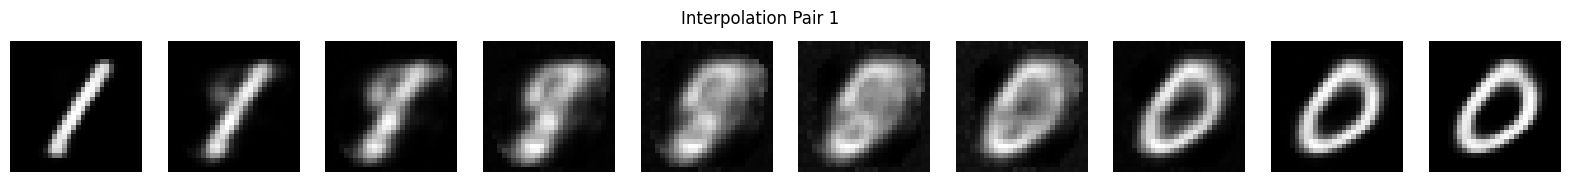

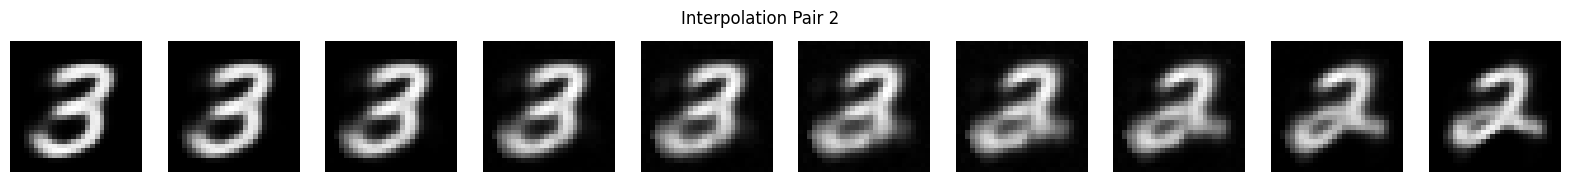

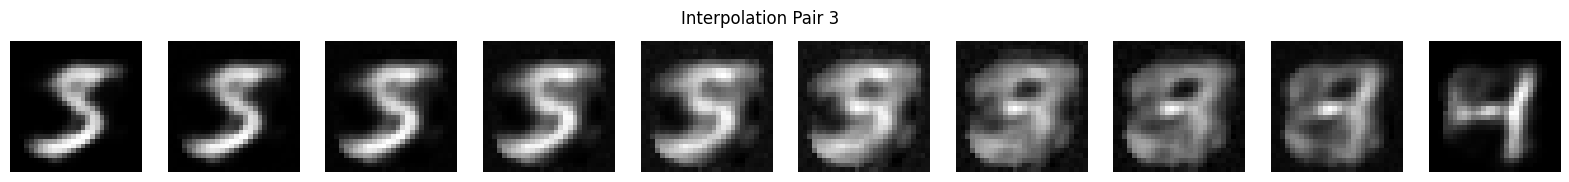

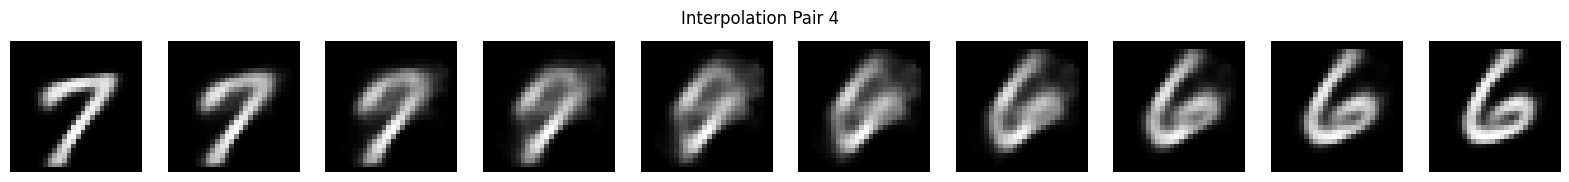

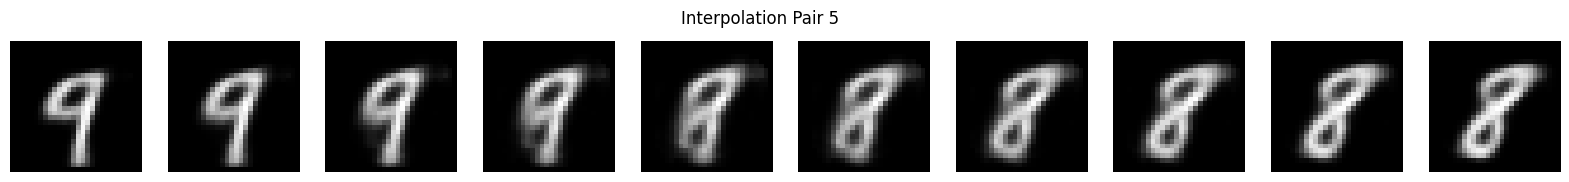

In [12]:
# Plot interpolations for each model
for name in models:
    print(f"Interpolations for model: {name}")
    plot_interpolations(models[name], pairs)